In [13]:
%matplotlib inline 
import torch
import torch.nn as nn
from torch.autograd import Variable
import time
import matplotlib.pyplot as plt
import torch.backends.cudnn as cudnn


def get_conv(filter_num, param):
    return nn.Conv2d(filter_num, filter_num, param["kernel_size"],
                     groups=filter_num if param["sep"] else 1,
                     padding=param["padding"], bias=False)

image_size = 32
batch_num = 32
layer_num = 16
filter_nums = [8, 16, 32, 64]
use_gpu = True
# use_gpu = False

params = {
    "conv5x5": {"kernel_size": 5, "sep": False, "padding": 2},
    "conv3x3": {"kernel_size": 3, "sep": False, "padding": 1},
    "conv3x3sep": {"kernel_size": 3, "sep": True, "padding": 1},
    "conv1x1": {"kernel_size": 1, "sep": False, "padding": 0},
    "conv1x3": {"kernel_size": (1, 3), "sep": False, "padding": (0, 1)},
    "conv3x1": {"kernel_size": (3, 1), "sep": False, "padding": (1, 0)}
}

results = {}

for name, param in params.items():
    timings = []

    for filter_num in filter_nums:
        layers = [get_conv(filter_num, param) for _ in range(layer_num)]
        model = nn.Sequential(*layers)
        
        if use_gpu:
            cudnn.benchmark = True
            cudnn.fastest = True
            input = Variable(torch.randn(batch_num, filter_num, image_size, image_size).cuda())
            model.cuda()            
        else:
            input = Variable(torch.randn(batch_num, filter_num, image_size, image_size))
            
        out = model(input)

        start = time.time()

        for i in range(100):
            out = model(input)

        elapsed_time = time.time() - start
        timings.append(elapsed_time)

    results[name] = timings

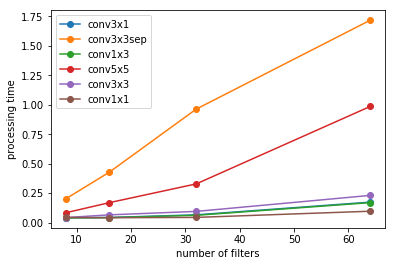

In [14]:
for name in params.keys():
    plt.plot(filter_nums, results[name], label=name, marker="o")

plt.xlabel("number of filters")
plt.ylabel("processing time")
plt.legend()

In [15]:
convs = ["conv1x1", "conv3x1", "conv1x3", "conv3x3sep", "conv3x3", "conv5x5"]

print("||" + "|".join(convs) + "|")
print("|:-:|:-:|:-:|:-:|:-:|:-:|:-:|")
print("|processing time [sec]|" + "|".join(["{:0.3f}".format(results[n][-1]) for n in convs]) + "|")
print("|vs 3x3|" + "|".join(["{:0.3f}".format(results[n][-1]/results["conv3x3"][-1]) for n in convs]) + "|")
print("|theoretical complexity|0.111|0.333|0.333|0.016|1.000|2.778|")

||conv1x1|conv3x1|conv1x3|conv3x3sep|conv3x3|conv5x5|
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
|processing time [sec]|0.096|0.173|0.169|1.717|0.230|0.985|
|vs 3x3|0.416|0.752|0.733|7.460|1.000|4.280|
|theoretical complexity|0.111|0.333|0.333|0.016|1.000|2.778|
